# Diffusion probabilistic models - Score matching

<a href="https://colab.research.google.com/github/acids-ircam/diffusion_models/blob/master/jax_tutorials/diffusion_01_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Author : Philippe Esling (esling@ircam.fr)

__JAX port by [Cristian Garcia](https://github.com/cgarciae)__

This notebook explores the new class of generative models based on _diffusion probabilistic models_ [ [ 1 ] ](#ref1). This class of models is inspired by considerations from thermodynamics [ [ 2 ] ](#ref2), but also bears strong ressemblence to _denoising score matching_ [ [ 3 ] ](#ref3), _Langevin dynamics_ and _autoregressive decoding_. We will also discuss the more recent development of _denoising diffusion implicit models_ [ [ 4 ] ](#ref4), which bypass the need for a Markov chain to accelerate the sampling. Stemming from this work, we will also discuss the _wavegrad_ model [ [ 5 ] ](#ref5), which is based on the same core principles but applies this class of models for audio data. 

In order to fully understand the inner workings of diffusion model, we will review all of the correlated topics. Therefore, we split the explanation between four detailed notebooks.
   1. Score matching and Langevin dynamics.
   2. Diffusion probabilistic models and denoising
   3. Applications to waveforms with WaveGrad
   4. Implicit models to accelerate inference

## Score matching

In this section we start by reviewing all the foundations on **score matching** that can lead to fully understand diffusion models. To do so, we will work on the traditional _swiss roll_ dataset.

(10000, 2)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Courier New


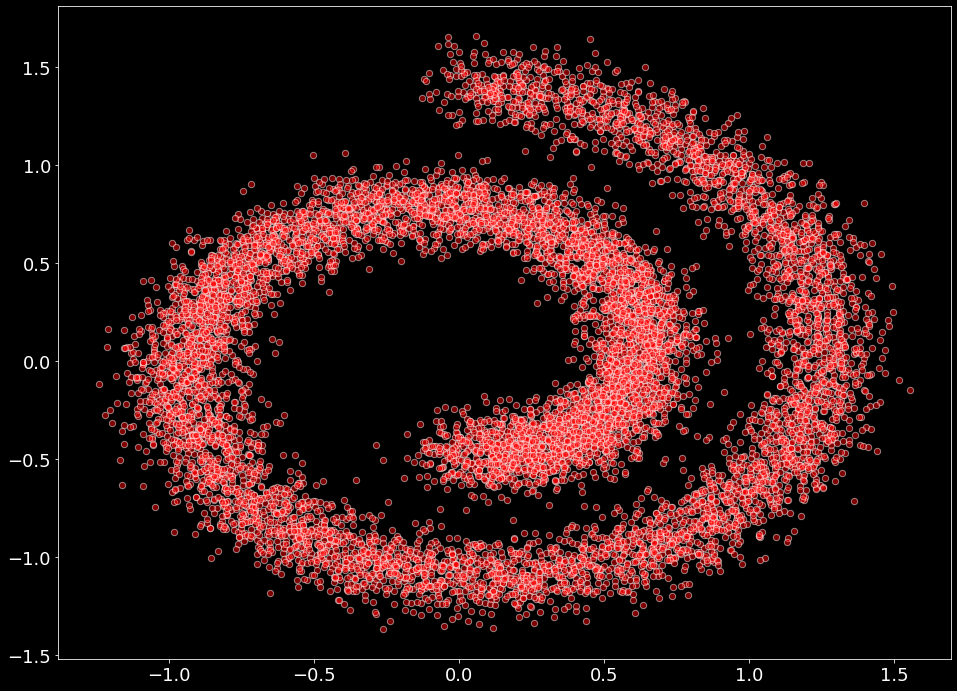

In [2]:
%matplotlib inline
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from sklearn.datasets import make_swiss_roll
from helper_plot import hdr_plot_style
from matplotlib import animation

hdr_plot_style()

Path("outputs").mkdir(exist_ok=True)

# Sample a batch from the swiss roll
def sample_batch(size, noise=1.0):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0
# Plot it
data = sample_batch(10**4).T
plt.figure(figsize=(16, 12))
plt.scatter(*data, alpha=0.5, color='red', edgecolor='white', s=40)

data = data.T
data.shape

The idea of _score matching_ was originally proposed by Hyvarinen et al. [ [ 6 ] ](#ref6). Instead of learning directly the probability of the data $\log p(\mathbf{x})$, we rather aim to learn the _gradients_ of $\log p(\mathbf{x})$ with respect to $x$. In this case, the gradients $\nabla_{\mathbf{x}} \log p(\mathbf{x})$ are termed the _score_ of the density $p(\mathbf{x})$, hence the name _score matching_. This can be understood as learning the _direction of highest probability_ at each point in the input space. Therefore, when the model is trained, we can improve a sample $x$ by moving it along the directions of highest probability. 

However, to perform training, we would need to minimize the error of our model $\mathcal{F}_{\theta}(\mathbf{x})$ at predicting the gradient $\nabla_{\mathbf{x}} \log p(\mathbf{x})$, which amounts to minimize the Fisher divergence, or simply the MSE

$$ \mathcal{L}_{mse} = E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\lVert \mathcal{F}_{\theta}(\mathbf{x}) - \nabla_{\mathbf{x}} \log p(\mathbf{x}) \right\lVert_2^2 \right] $$

The real $\nabla_{\mathbf{x}} \log p(\mathbf{x})$ is usually unknown, but under regularity assumptions on $p(\mathbf{x})$, it can be shown that the minimum of $\mathcal{L}_{mse}$ can be found through a tractable objective

$$ \mathcal{L}_{matching} = E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})  \right) + \frac{1}{2} \left\Vert \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2 \right]
, $$

where $\nabla_{\mathbf{x}} \mathcal{F}_{\theta}(\mathbf{x})$ denotes the Jacobian of $\mathcal{F}_{\theta}(\mathbf{x})$ with respect to $\mathbf{x}$, and $ \text{tr}(\cdot) $ is the _trace_ operation.

To perform this optimization, we will rely on `JAX` and `treex` to define $\mathcal{F}_{\theta}(\mathbf{x})$ as being a neural network

In [3]:
import treex as tx
import optax

# Our approximation model
model = tx.Sequential(
    tx.Linear(128), jax.nn.softplus,
    tx.Linear(128), jax.nn.softplus,
    tx.Linear(2)
).init(42, data)

# Create a jited forward function
@jax.jit
def forward(model, x):
    return model(x)

# Create ADAM optimizer over our model
optimizer = tx.Optimizer(optax.adamw(1e-3)).init(model)

Next, we need to define the loss function for the _score matching_ objective. The actual _score matching_ loss function is split between the norm of the model output $\frac{1}{2} \left\Vert \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2$, which we compute first. Then, we compute the trace of the Jacobian loss $\text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x}) \right)$ and return the sum as the full loss. 

In [4]:
@jax.jit
def score_matching(model, samples):
    N = np.prod(samples.shape)
    logp = model(samples)
    # Compute the norm loss
    norm_loss = jnp.linalg.norm(logp, axis=-1) ** 2 / 2.0

    # Per-sample forward pass
    def _sample_forward(sample):
        return model(sample[None])[0]

    # Compute the Jacobian loss
    jacob_mat = jax.vmap(jax.jacrev(_sample_forward))(samples)
    tr_jacobian_loss = jnp.trace(jacob_mat, axis1=-2, axis2=-1)
    
    return (tr_jacobian_loss + norm_loss).mean()

Finally, we can run our code to train the model

In [5]:
from tqdm import tqdm

steps = 50_000

@jax.jit
def train_step(model, optimizer, samples):
    grads = jax.grad(score_matching)(model, samples)
    model = optimizer.update(grads, model)
    return model, optimizer

for t in tqdm(range(steps + 1)):
    batch_idxs = np.random.choice(data.shape[0], size=128, replace=False)
    model, optimizer = train_step(model, optimizer, data[batch_idxs])
    if ((t % (steps // 5)) == 0):
        print(score_matching(model, data))

  0%|          | 51/50001 [00:01<23:16, 35.78it/s]  

0.34206453


 20%|██        | 10070/50001 [00:21<01:22, 486.42it/s]

-44.447685


 40%|████      | 20070/50001 [00:40<01:00, 497.14it/s]

-48.763012


 60%|██████    | 30058/50001 [01:00<00:39, 500.94it/s]

-49.506447


 80%|████████  | 40075/50001 [01:19<00:19, 504.55it/s]

-50.435467


100%|██████████| 50001/50001 [01:38<00:00, 509.03it/s]

-50.478943


We can observe that our model has learned to represent $\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_x \log p(x)$ by plotting the output value across the input space

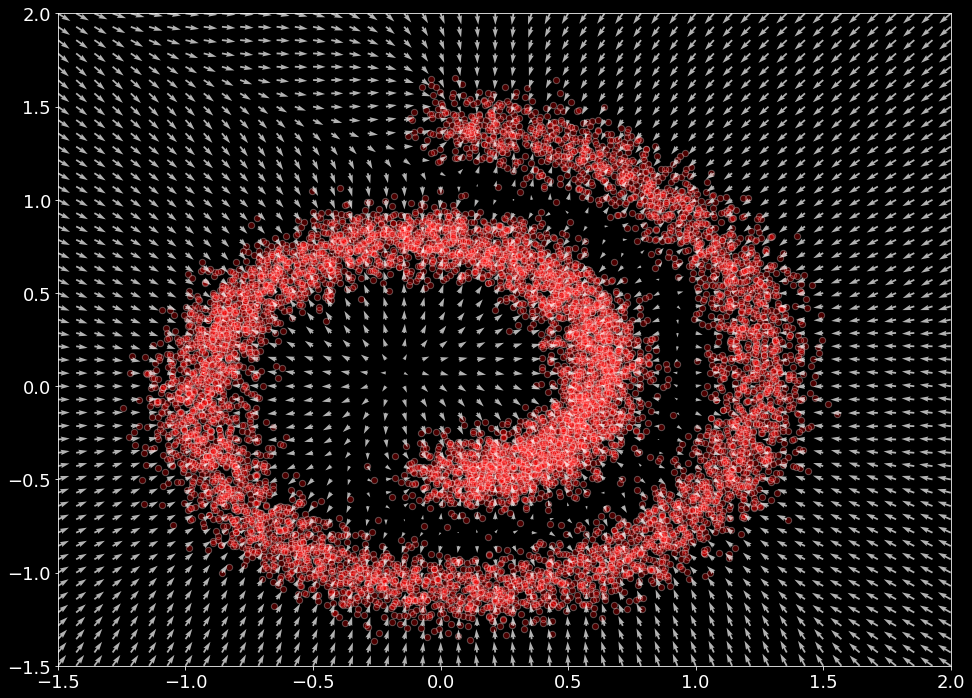

In [6]:
def plot_gradients(model, data, xlim=(-1.5, 2.0), ylim=(-1.5, 2.0), nx=50, ny=50, plot_scatter=True, alpha=1.0):
    xx = np.stack(np.meshgrid(np.linspace(*xlim, nx), np.linspace(*ylim, ny)), axis=-1).reshape(-1, 2)
    scores = forward(model, xx)
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    # Perform the plots
    
    if plot_scatter:
        plt.figure(figsize=(16,12))
        plt.scatter(data[:, 0], data[:, 1], alpha=0.3, color='red', edgecolor='white', s=40)
        plt.xlim(-1.5, 2.0)
        plt.ylim(-1.5, 2.0)
    
    quiver = plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white', alpha=alpha)
    
    return quiver

def make_animation(Xt):
    X0 = np.tile(Xt[:1], (10, 1, 1))
    Xf = np.tile(Xt[-1:], (10, 1, 1))
    Xt = jnp.concatenate([X0, Xt, Xf])

    fig = plt.figure(figsize=(14, 10))
    ax = plt.gca()

    xlim = (Xt[..., 0].min() * 0.7, Xt[..., 0].max() * 0.7)
    ylim = (Xt[..., 1].min() * 0.7, Xt[..., 1].max() * 0.7)

    quiver = plot_gradients(model, data, xlim=xlim, ylim=ylim, nx=35, ny=35, plot_scatter=False, alpha=0.5)

    ax.axis("off")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

    scatter = ax.scatter(Xt[0, :, 0], Xt[0, :, 1])

    def animate(i):
        scatter.set_offsets(Xt[i])
        return (quiver, scatter,)

    anim = animation.FuncAnimation(
        fig,
        animate,
        init_func=lambda: animate(0),
        frames=range(0, len(Xt)),
        interval=100,
        repeat_delay=1000,
        blit=True,
    )

    return anim

plot_gradients(model, data, alpha=0.7);

### Langevin dynamics

After training, our model is able to produce an approximation of the gradient of the probabiliity, such that $\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_x \log p(x)$. Therefore, we could use this to generate data by relying on a simple gradient ascent from a given point by using an initial sample $\mathbf{x}_{0} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$, and then using the gradient information to find a local maximum of $p(\mathbf{x})$

$$\mathbf{x}_{t + 1} = \mathbf{x}_t + \epsilon \nabla_{\mathbf{x}_t} log p(\mathbf{x}_t)$$

where $\epsilon$ defines the size of the step we take in the direction of the gradient (akin to the _learning rate_).

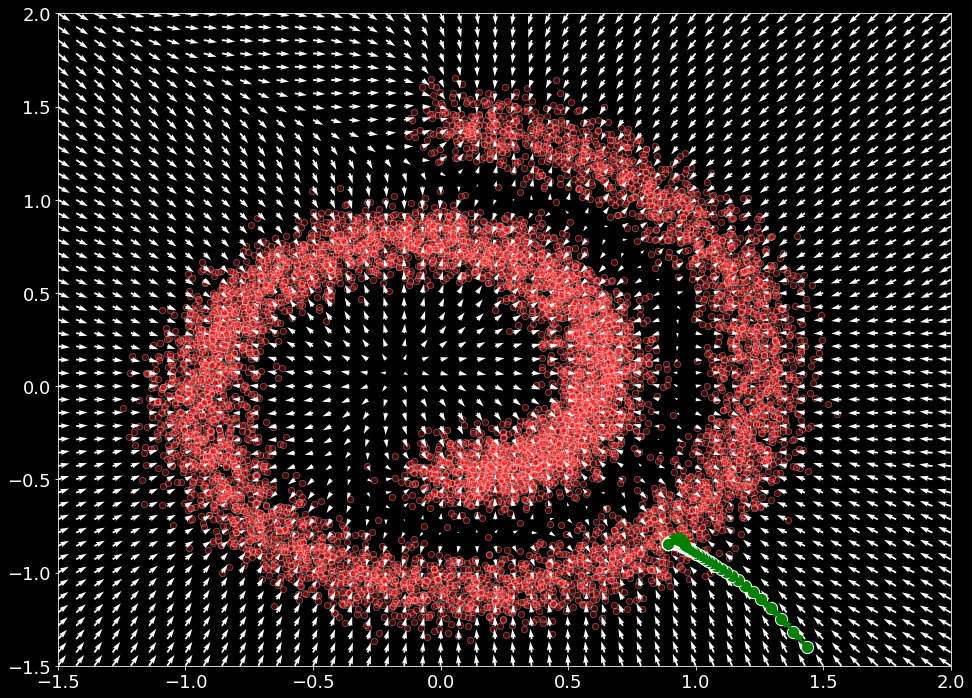

In [24]:
@jax.jit
def sample_simple(model, x, n_steps=70, eps=1e-3):
    # create a step function to pass to jax.scan
    def step(x, i):
        x = x + eps * forward(model, x)
        return x, x

    return jax.lax.scan(step, x, np.arange(n_steps))[1]


x = jnp.array([1.5, -1.5])[None]
samples = sample_simple(model, x)[:, 0]
plot_gradients(model, data)
plt.scatter(samples[:, 0], samples[:, 1], color='green', edgecolor='white', s=150)
# draw arrows for each  step
deltas = (samples[1:] - samples[:-1])
deltas = deltas - deltas / np.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
for i, arrow in enumerate(deltas):
    plt.arrow(samples[i,0], samples[i,1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color="green", linewidth=3)

To get a more general idea of what is happening lets create an animation of the process using many random data points.

In [22]:
from IPython import display

x = np.random.normal(size=(500, 2))
samples = sample_simple(model, x)

anim = make_animation(samples)

print("Saving animation...")
anim.save("outputs/sample_simple.gif", writer="imagemagick")
plt.close()

display.Markdown("![sample_simple](outputs/sample_simple.gif)")

Saving animation...


![sample_simple](outputs/sample_simple.gif)

However, the previous procedure does not produce a true sample from $\mathbf{x} \sim p(\mathbf{x})$. In order to obtain such a sample, we can rely on a special case of _Langevin dynamics_. In this case, _Langevin dynamics_ can produce true samples from the density $p(\mathbf{x})$, by relying only on $\nabla_{\mathbf{x}} \log p(\mathbf{x})$. The sampling is defined in a way very similar to MCMC approaches, by applying recursively

$$\mathbf{x}_{t + 1} = \mathbf{x}_t + \frac{\epsilon}{2} \nabla_{\mathbf{x}_t} log p(\mathbf{x}_t) + \sqrt{\epsilon} \mathbf{z}_{t}$$

where $\mathbf{z}_{t}\sim \mathcal{N}(\mathbf{0},\mathbf{I})$. It has been shown in [Welling et al. (2011)](https://www.ics.uci.edu/~welling/publications/papers/stoclangevin_v6.pdf) that under $\epsilon \rightarrow 0, t \rightarrow \inf$: $\mathbf{x}_t$ converges to an exact sample from $p(\mathbf{x})$. This is a key idea behind the _score-based generative modeling_ approach.

In order to implement this sampling procedure, we can once again start from $\mathbf{x}_{0} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$, and progressively anneal $\epsilon \rightarrow 0$ at each step, to obtain true samples from $p(\mathbf{x})$.

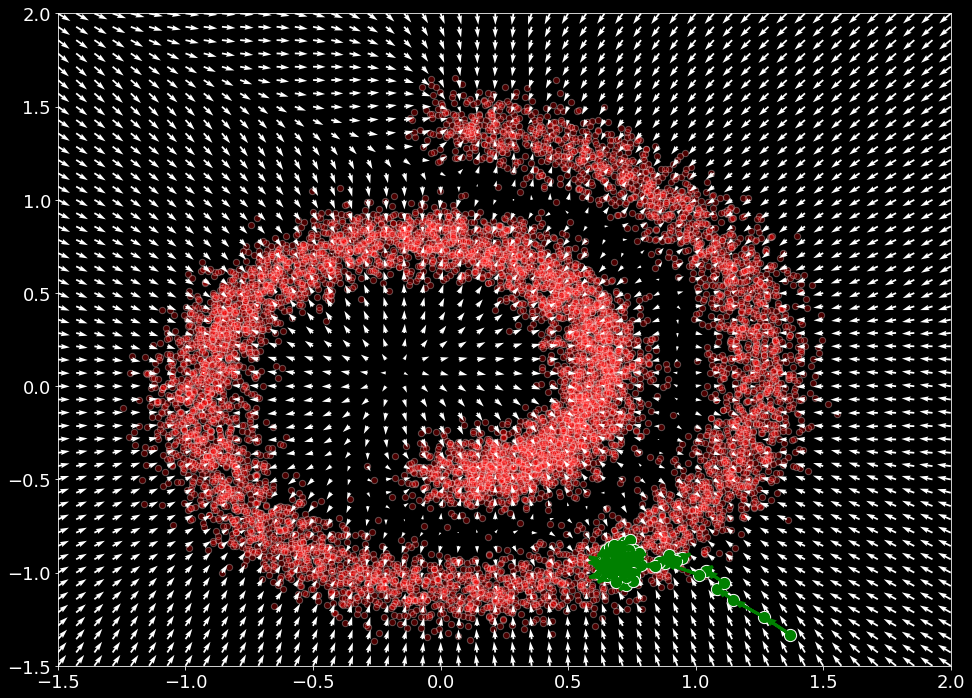

In [39]:

@jax.jit
def sample_langevin(model, x, key_seq, n_steps=100, eps=4e-3, decay=0.97, temperature=0.7):
    # create a step function to pass to jax.scan
    def step(state, i):
        x, key_seq, eps = state
        z_t = jax.random.normal(key_seq(), shape=x.shape)
        x = x + (eps / 2) * forward(model, x) + (jnp.sqrt(eps) * temperature * z_t)
        eps *= decay
        return (x, key_seq, eps), x

    return jax.lax.scan(step, (x, key_seq, eps), np.arange(n_steps))[1]

x = jnp.array([1.5, -1.5])[None]
key_seq = tx.KeySeq(0)
samples = sample_langevin(model, x, key_seq)[:, 0]
plot_gradients(model, data)
plt.scatter(samples[:, 0], samples[:, 1], color='green', edgecolor='white', s=150)
# draw arrows for each mcmc step
deltas = (samples[1:] - samples[:-1])
deltas = deltas - deltas / np.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
for i, arrow in enumerate(deltas):
    plt.arrow(samples[i,0], samples[i,1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color="green", linewidth=3)

We will again create an animation of the process, notice that the Langevin dynamics is less smooth but more approximates the data distribution better.

In [27]:
x = np.random.normal(size=(500, 2))
key = jax.random.PRNGKey(0)
samples = sample_langevin(model, x, key)

anim = make_animation(samples)

print("Saving animation...")
anim.save("outputs/sample_langevin.gif", writer="imagemagick")
plt.close()

display.Markdown("![sample_langevin](outputs/sample_langevin.gif)")

Saving animation...


![sample_langevin](outputs/sample_langevin.gif)

### Sliced score matching

The previously defined _score matching_ with this loss is not scalable to high-dimensional data, nor deep networks, because of the computation of $\text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})  \right)$. Indeed, the computation of the Jacobian is a $O(N^2 + N)$ operation, thus not being suitable for high-dimensional problems, even with the optimized solution proposed in the previous code. More recently, Song et al. [ [ 7 ] ](#ref7) proposed to use random projections to approximate the computation of $\text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})  \right)$ in score matching. This approach called _Sliced Score Matching_ allows to replace the optimization objective with

$$ E_{\mathbf{v} \sim \mathcal{N}(0, 1)} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \mathbf{v}^T \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x}) \mathbf{v} + \frac{1}{2} \left\Vert \mathbf{v}^T \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2 \right]
, $$

where $\mathbf{v} \sim \mathcal{N}(0, 1)$ are a set of Normal-distributed vectors. They show that this can be computed by using forward mode auto-differentiation, which is computationally efficient. This loss can be implemented as follows (where we compute once again the norm first, and then the Jacobian loss)

In [41]:
def sliced_score_matching(model, samples, key):
    # Construct random vectors
    vectors = jax.random.normal(key, shape=samples.shape)
    vectors = vectors / jnp.linalg.norm(vectors, axis=-1, keepdims=True)
    # Compute the optimized vector-product jacobian
    # logp, jvp = autograd.functional.jvp(model, samples, vectors, create_graph=True)
    logp, jvp = jax.jvp(model, (samples,), (vectors,))
    # Compute the norm loss
    norm_loss = (logp * vectors) ** 2 / 2.
    # Compute the Jacobian loss
    v_jvp = jvp * vectors
    jacob_loss = v_jvp
    loss = jacob_loss + norm_loss
    return loss.mean(-1).mean(-1)


sliced_score_matching(model, data[:10], jax.random.PRNGKey(0))

DeviceArray(0.23378812, dtype=float32)

As previously, we can perform a simple optimization of this loss given a set of examples.

In [43]:
# Our approximation model
model = tx.Sequential(
    tx.Linear(128), jax.nn.softplus,
    tx.Linear(128), jax.nn.softplus,
    tx.Linear(2)
).init(42, data)
# Create ADAM optimizer over our model
# Create a jited forward function
@jax.jit
def forward(model, x):
    return model(x)

# Create ADAM optimizer over our model
optimizer = tx.Optimizer(optax.adamw(1e-3)).init(model)

steps = 60_000

@jax.jit
def train_step(model, optimizer, key_seq, samples):
    grads = jax.grad(sliced_score_matching)(model, samples, key_seq())
    model = optimizer.update(grads, model)
    return model, optimizer, key_seq

key_seq = tx.KeySeq(0)
for t in tqdm(range(steps + 1)):
    batch_idxs = np.random.choice(data.shape[0], size=128, replace=False)
    model, optimizer, key_seq = train_step(model, optimizer, key_seq, data[batch_idxs])
    if ((t % (steps // 5)) == 0):
        print(sliced_score_matching(model, data, key_seq()))

  0%|          | 72/60001 [00:02<27:40, 36.09it/s]  

0.08545301


 20%|██        | 12093/60001 [00:19<01:35, 499.71it/s]

-11.524573


 40%|████      | 24111/60001 [00:37<01:10, 509.62it/s]

-11.991187


 60%|██████    | 36089/60001 [00:53<00:45, 520.45it/s]

-12.238484


 80%|████████  | 48142/60001 [01:10<00:22, 536.42it/s]

-12.7034235


100%|██████████| 60001/60001 [01:26<00:00, 692.42it/s]

-12.327543


We can check our approximation by relying on the same function as before.

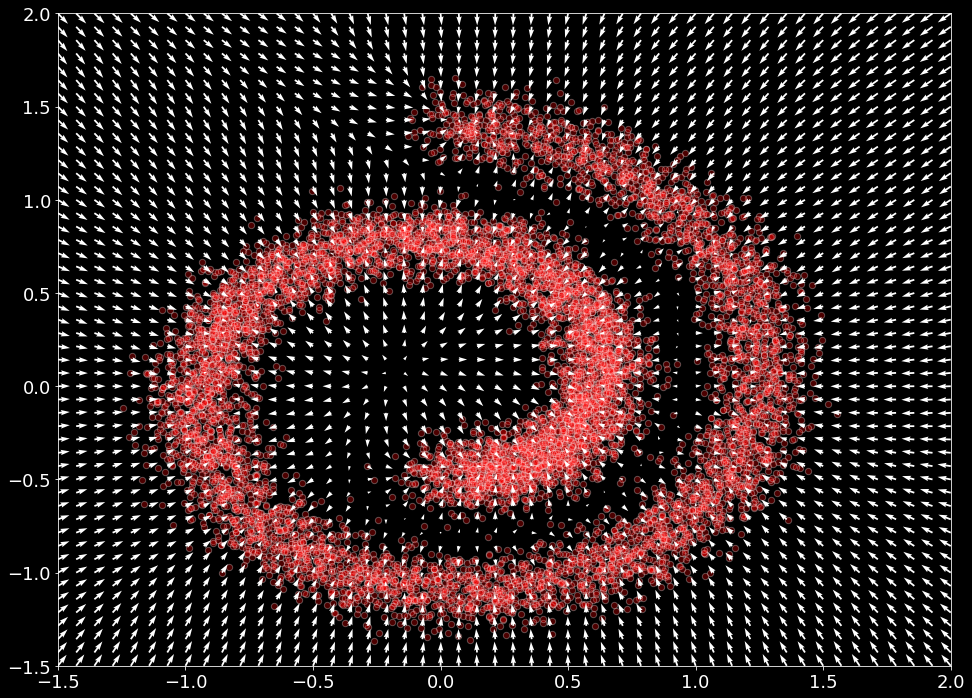

In [44]:
plot_gradients(model, data)

### Denoising score matching

Originally, the notion of _denoising score matching_ was discussed by Vincent [ [ 3 ] ](#ref3) in the context of _denoising auto-encoders_. In that case, this allows to completely remove the use of $\nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})$ in the computation of score matching. To do so, we can first corrupt the input point $\mathbf{x}$ with a given noise vector, leading to a distribution $q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})$. Then, score matching can be used to estimate the score of this perturbed data distribution. It has been shown in [3], that the optimal network that approximates $\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \log p(\mathbf{x})$ can be found by minimizing the following objective

$$ E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\Vert \mathcal{F}_{\theta}(\tilde{\mathbf{x}}) - \nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x}) \right\lVert_2^2 \right]
, $$

However, it should be noted that $\mathcal{F}_{\theta}(\mathbf{x}) = \nabla_{\mathbf{x}} \log q_{\sigma}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \log p(\mathbf{x})$ is only true when the noise is small enough to consider that $q_{\sigma}(\mathbf{x}) \approx p(\mathbf{x})$. As it has been shown in [ [ 3 ] ](#ref3),[ [ 8 ] ](#ref8), if we choose the noise distribution to be $q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})=\mathcal{N}(\tilde{\mathbf{x}}\mid\mathbf{x}, \sigma^{2}\mathbf{I})$, then we have $\nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x}) = \frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}}$. Therefore, the denoising score matching loss simply becomes

$$ \mathcal{l}(\theta;\sigma) = E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\Vert \mathcal{F}_{\theta}(\tilde{\mathbf{x}}) +  \frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}} \right\lVert_2^2 \right]
, $$

We can implement the _denoising score matching_ loss as follows

In [47]:
def denoising_score_matching(scorenet, samples, key, sigma=0.01):
    noise = jax.random.normal(key, samples.shape)
    perturbed_samples = samples + noise * sigma
    target = -noise / sigma
    scores = scorenet(perturbed_samples)
    loss = 1 / 2. * ((scores - target) ** 2).sum(axis=-1).mean(axis=0)
    return loss

denoising_score_matching(model, data[:10], jax.random.PRNGKey(0))

DeviceArray(14291.695, dtype=float32)

We rely on the same model and optimizer as before

In [48]:
# Our approximation model
model = tx.Sequential(
    tx.Linear(128), jax.nn.softplus,
    tx.Linear(128), jax.nn.softplus,
    tx.Linear(2)
).init(42, data)
# Create ADAM optimizer over our model
# Create a jited forward function
@jax.jit
def forward(model, x):
    return model(x)

# Create ADAM optimizer over our model
optimizer = tx.Optimizer(optax.adamw(1e-3)).init(model)

steps = 60_000
key_seq = tx.KeySeq(0)

@jax.jit
def train_step(model, optimizer, key_seq, samples):
    grads = jax.grad(denoising_score_matching)(model, samples, key_seq())
    model = optimizer.update(grads, model)
    return model, optimizer, key_seq

for t in tqdm(range(steps + 1)):
    batch_idxs = np.random.choice(data.shape[0], size=128, replace=False)
    model, optimizer, key_seq = train_step(model, optimizer, key_seq, data[batch_idxs])
    if ((t % (steps // 5)) == 0):
        print(denoising_score_matching(model, data, key_seq()))

  0%|          | 192/60001 [00:02<06:27, 154.35it/s]

10120.559


 20%|██        | 12139/60001 [00:14<01:08, 703.29it/s]

10241.94


 40%|████      | 24117/60001 [00:27<00:47, 754.91it/s]

9992.008


 60%|██████    | 36107/60001 [00:40<00:32, 738.35it/s] 

10190.788


 80%|████████  | 48140/60001 [00:54<00:21, 549.29it/s] 

9934.7295


100%|██████████| 60001/60001 [01:08<00:00, 878.56it/s] 

10017.908


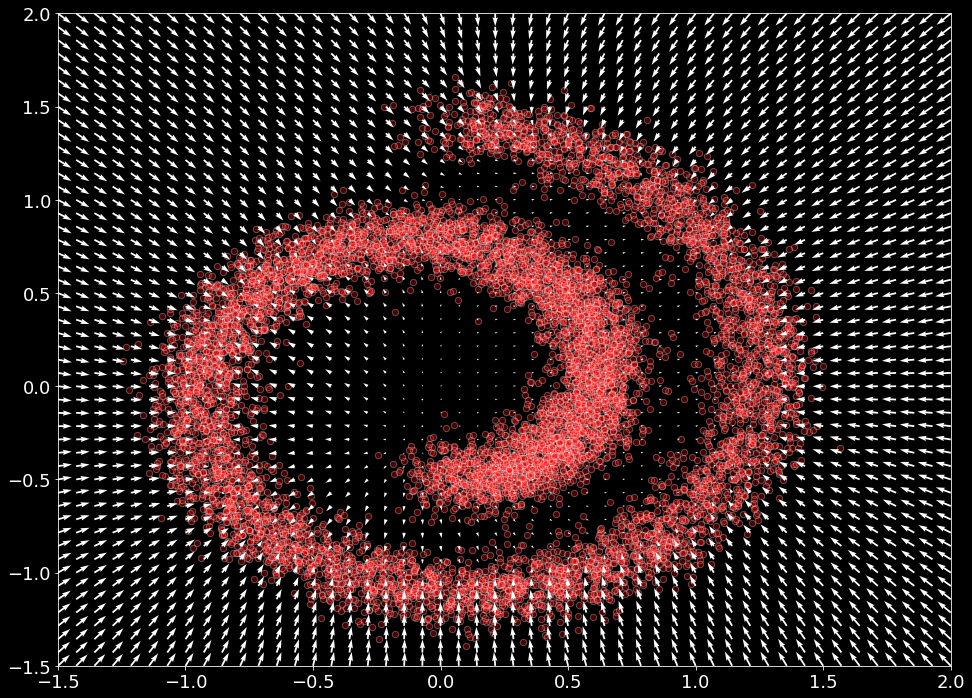

In [49]:
plot_gradients(model, data)

### Noise conditional score networks

In a recent paper, Song and Ermon [ [ 8 ] ](#ref8) built on these ideas to develop a score-based generative framework called _Noise-Conditional Score Networks_ (NCSN). They underlined several flaws in the existing score matching objectives. First, they showed that the use of (sliced) score matching without noise was inconsistent when the data followed the manifold hypothesis, ie. the noiseless objectives were only consistent when the distribution spanned the whole space. Second, they showed that low density regions could cause difficulties for both score matching and sampling with Langevin dynamics.

To address these issues, they propose to rely on perturbed data to bypass the manifold issues, but also to simultaneously estimate scores corresponding to all noise levels by training a single conditional score network. To do so, we consider a positive geometric sequence of noise variances $\{\sigma_{i}\}_{i=1}^{L}$, choosing $\sigma_{1}$ to be large enough to mitigate manifold issue, and satisfying $\frac{\sigma_{1}}{\sigma_{2}} = \cdots = \frac{\sigma_{L-1}}{\sigma_{L}} > 1$. The goal is to train a conditional network to estimate the gradients of all perturbed data distributions, ie.
$$
\forall \sigma \in \{\sigma_{i}\}_{i=1}^{L}, \mathcal{F}_{\theta}(\tilde{\mathbf{x}}, \sigma) \approx \nabla_{\mathbf{x}} \log q_{\sigma}(\mathbf{x})
$$
The network learning this is called a _Noise Conditional Score Network_ (NCSN). To perform this optimization, we start from the previously-defined denoising score matching objective
$$ \mathcal{l}(\theta;\sigma) = E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\Vert \mathcal{F}_{\theta}(\tilde{\mathbf{x}}, \sigma) +  \frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}} \right\lVert_2^2 \right]
, $$
As this adress a single noise level, this objective can be combined to obtain a single unified objective as
$$
\mathcal{L}(\theta;\{\sigma_{i}\}_{i=1}^{L}) = \frac{1}{L} \sum_{i=1}^{L} \lambda(\sigma_{i})\mathcal{l}(\theta;\sigma_{i})
$$
where $\lambda(\sigma_{i}) > 0$ is a coefficient function depending on $\sigma_{i}$. This objective can be implemented as follows

In [49]:
def anneal_dsm_score_estimation(model, samples, labels, sigmas, key, anneal_power=2.):
    sigmas = sigmas[..., None]
    noise = jax.random.normal(key, samples.shape)
    perturbed_samples = samples + noise * sigmas
    target = -noise / sigmas
    scores = model(perturbed_samples, labels)
    loss = 1 / 2. * ((scores - target) ** 2).sum(axis=-1) * sigmas.squeeze() ** anneal_power
    return loss.mean(axis=0)


As can be seen in the previous equation, this model requires a _conditional_ network $\mathcal{F}_{\theta}(\tilde{\mathbf{x}}, \sigma_{i})$ that also takes as input the different noise levels $\sigma_{i}$. Therefore, we redefine the previous model to account for that

In [52]:
class ConditionalLinear(tx.Module):
    def __init__(self, num_out, num_classes):
        super().__init__()
        self.num_out = num_out
        self.lin = tx.Linear(num_out)
        self.embed = tx.Embed(num_classes, num_out)

    def __call__(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        return gamma * out
    
class ConditionalModel(tx.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.lin1 = ConditionalLinear(128, num_classes)
        self.lin2 = ConditionalLinear(128, num_classes)
        self.lin3 = tx.Linear(2)
    
    def __call__(self, x, y):
        x = jax.nn.softplus(self.lin1(x, y))
        x = jax.nn.softplus(self.lin2(x, y))
        return self.lin3(x)

Finally, we can perform the same optimization as before

In [53]:
sigma_begin = 1
sigma_end = 0.01
num_classes = 10
sigmas = np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end), num_classes))
# Our approximation model
model = ConditionalModel(num_classes).init(42, (data[:10], np.zeros((10,), dtype=np.int32)))
# Create ADAM optimizer over our model
optimizer = tx.Optimizer(optax.adamw(1e-3)).init(model)

steps = 60_000

@jax.jit
def train_step(model, optimizer, key_seq, samples, labels, sigmas):
    grads = jax.grad(anneal_dsm_score_estimation)(model, samples, labels, sigmas, key_seq())
    model = optimizer.update(grads, model)
    return model, optimizer, key_seq

key_seq = tx.KeySeq(0)
for t in tqdm(range(steps + 1)):
    batch_idxs = np.random.choice(data.shape[0], size=128, replace=False)
    labels = np.random.randint(0, len(sigmas), size=len(batch_idxs))
    model, optimizer, key_seq = train_step(model, optimizer, key_seq, data[batch_idxs], labels, sigmas[labels])
    if ((t % (steps // 5)) == 0):
        labels = np.random.randint(0, len(sigmas), size=len(data))
        print(anneal_dsm_score_estimation(model, data, labels, sigmas[labels], key_seq()))

  0%|          | 84/60001 [00:02<20:29, 48.73it/s]  

1.0220436


 20%|██        | 12141/60001 [00:17<01:30, 529.43it/s]

0.84418416


 40%|████      | 24109/60001 [00:33<01:03, 565.99it/s]

0.8166828


 60%|██████    | 36126/60001 [00:48<00:47, 504.06it/s]

0.8155382


 80%|████████  | 48086/60001 [01:04<00:26, 448.53it/s]

0.7937906


100%|██████████| 60001/60001 [01:21<00:00, 739.41it/s]

0.78239226


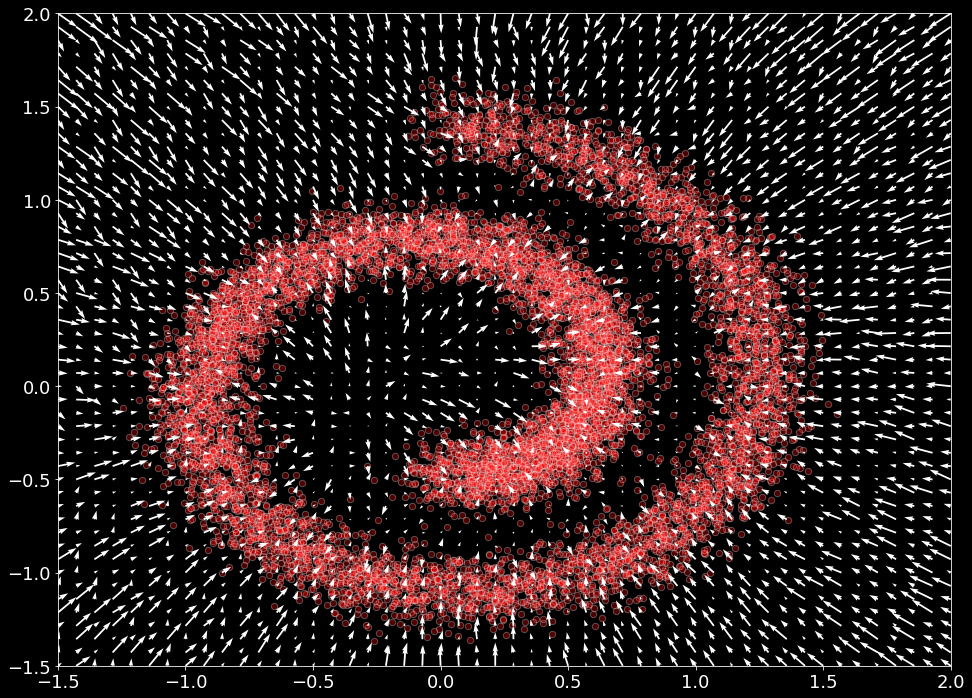

In [54]:
xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
labels = np.random.randint(0, len(sigmas), (xx.shape[0],))
scores = model(xx, labels)
scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
# Perform the plots
plt.figure(figsize=(16,12))
plt.scatter(*data.T, alpha=0.3, color='red', edgecolor='white', s=40)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white')
plt.xlim(-1.5, 2.0)
plt.ylim(-1.5, 2.0);

(-1.5, 2.0)

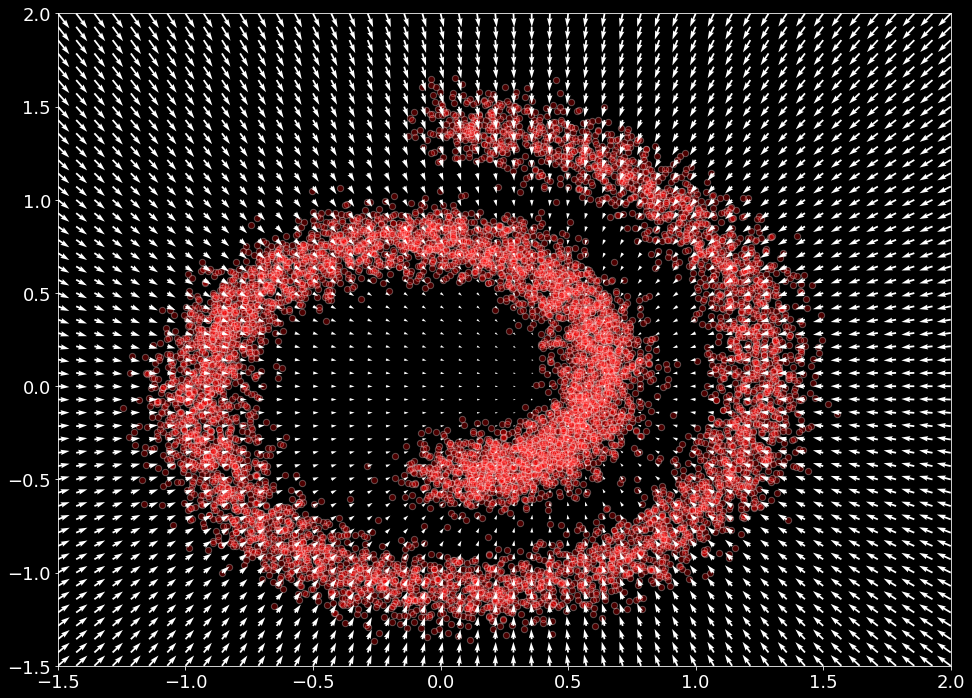

In [55]:
xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
labels = np.zeros(xx.shape[0], dtype=np.int32) + 1
scores = model(xx, labels)
scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
# Perform the plots
plt.figure(figsize=(16,12))
plt.scatter(*data.T, alpha=0.3, color='red', edgecolor='white', s=40)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white')
plt.xlim(-1.5, 2.0)
plt.ylim(-1.5, 2.0)

## Bibliography

<a id="ref1"/>

[1] [Ho, J., Jain, A., & Abbeel, P. (2020). _Denoising diffusion probabilistic models_. arXiv preprint arXiv:2006.11239.](https://arxiv.org/pdf/2006.11239)

<a id="ref2"/>

[2] [Sohl-Dickstein, J., Weiss, E. A., Maheswaranathan, N., & Ganguli, S. (2015). Deep unsupervised learning using nonequilibrium thermodynamics. arXiv preprint arXiv:1503.03585.](https://arxiv.org/pdf/1503.03585)

<a id="ref3"/>

[3] [Vincent, P. (2011). A connection between score matching and denoising autoencoders. Neural computation, 23(7), 1661-1674.](http://www-labs.iro.umontreal.ca/~vincentp/Publications/smdae_techreport_1358.pdf)

<a id="ref4"/>

[4] [Song, J., Meng, C., & Ermon, S. (2020). Denoising Diffusion Implicit Models. arXiv preprint arXiv:2010.02502.](https://arxiv.org/pdf/2010.02502.pdf)

<a id="ref5"/>

[5] [Chen, N., Zhang, Y., Zen, H., Weiss, R. J., Norouzi, M., & Chan, W. (2020). _WaveGrad: Estimating gradients for waveform generation_. arXiv preprint arXiv:2009.00713.](https://arxiv.org/pdf/2009.00713)

<a id="ref6"/>

[6] [Hyvärinen, A. (2005). Estimation of non-normalized statistical models by score matching. Journal of Machine Learning Research, 6(Apr), 695-709.](http://jmlr.org/papers/volume6/hyvarinen05a/old.pdf)

<a id="ref7"/>

[7] [Song, Y., Garg, S., Shi, J., & Ermon, S. (2020, August). Sliced score matching: A scalable approach to density and score estimation. In Uncertainty in Artificial Intelligence (pp. 574-584). PMLR.](https://arxiv.org/pdf/1905.07088.pdf)

<a id="ref8"/>

[8] [Song, Y., & Ermon, S. (2019). Generative modeling by estimating gradients of the data distribution. In Advances in Neural Information Processing Systems (pp. 11918-11930).](https://arxiv.org/pdf/1907.05600.pdf)

### Inspiration and sources

https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/score_matching.ipynb

https://github.com/ermongroup/sliced_score_matching